# Hyperparameter optimization
- this notebook shows basic libraries and procedures used for hyperparameter optimization

# Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
RANDOM_STATE = 12

# Create dataset for binary classification
- function `make_classification` from sklearn.datasets allows to create dataset for multiclass classification problem. Inside several features are predictive, some features can be correlated and some features are uninformative with respect to target.
- through function parameters we can control number of predictive features, number of target classes and other characteristics of the sample

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
X, y = make_classification(
    n_samples=100000, 
    n_features=15, 
    n_informative=2, 
    n_redundant=2, 
    n_repeated=0,
    n_classes=2,
    flip_y=0.1,
    random_state=RANDOM_STATE
)

## Split sample
It is recommended to use stratification.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y
)

# Hyper-parameters optimization
Hyper-parameters are parameters not directly learned by estimator. They must be passed to the estimator as its parameters.

Search consists of:
- estimator
- parameter search space
- method for searching the space
- score function

Basic approaches for optimal hyper-parameters selection:
    
    1. Grid search
    2. Randomized grid search
    3. Grid search with halving
    4. Randomized grid search with halving
    
**Cross validation** is usually used during hyper-parameters optimization process.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

## Grid search
Perfoms exhaustive grid search - every combination from search space is evaluated.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params_grid = [
    {'max_depth': [2, 4, 8, 16], 'criterion': ['gini', 'entropy']},
#     {'min_samples_split': [100, 1000, 10000], 'ccp_alpha': [0.0, 0.0001, 0.00025]},
]

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

clf = GridSearchCV(
    estimator=tree, 
    param_grid=params_grid, 
    cv=3,
    scoring='roc_auc',
    error_score=0,
    refit=False
)

clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
pd.DataFrame(clf.cv_results_)

In [ ]:
param = 'criterion'

x = []
y = []
other_pars = []
i = 0
for pars in clf.cv_results_['params']:
    if param in pars:
        x.append(pars[param] or -999)
        y.append(clf.cv_results_['mean_test_score'][i])
        other_pars.append(', '.join([f'{p}:{v}' for p, v in pars.items() if p != param]))
        i += 1

encoding = {}
j = 1
for i in np.unique(x):
    encoding[i] = j
    j += 1
    
xe = [encoding[i] for i in x]

ax = plt.subplot(1,1,1)
for i in range(len(x)):
    ax.scatter(xe[i], y[i], label=other_pars[i])

ax.legend(bbox_to_anchor=(1.05, 1.02))
ax.set_xticks(xe)
ax.set_xticklabels(x, rotation = 90, color='gray')
ax.set_xlabel(param)
ax.set_ylabel('auc')
ax.tick_params(axis='y', colors='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.show()

## Randomized grid search
Parameter value is selected from a distribution of possible values.

- Number of evaluated combinations can be restricted independently on number of parameters and their possible values.
- Parameters with low impact do not decrease efficiency.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.stats import expon

In [14]:
params_dist = [
#     {'max_depth': [2, 3, 4, None], 'criterion': ['gini', 'entropy']},
    {'min_samples_split': np.unique(np.logspace(1, 4, num=30, dtype=np.int)), 'ccp_alpha': expon(scale=0.00025)},
]

tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=8)

# Budget is controlled through parameter n_iter
clf = RandomizedSearchCV(
    estimator=tree, 
    param_distributions=params_dist, 
    cv=3,
    scoring='roc_auc',
    n_iter = 8,
    error_score=0,
    refit=True,
    random_state=RANDOM_STATE
)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=0,
                   estimator=DecisionTreeClassifier(max_depth=8,
                                                    random_state=12),
                   n_iter=8,
                   param_distributions=[{'ccp_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019420FC94B0>,
                                         'min_samples_split': array([   10,    12,    16,    20,    25,    32,    41,    52,    67,
          85,   108,   137,   174,   221,   280,   356,   452,   573,
         727,   923,  1172,  1487,  1887,  2395,  3039,  3856,  4893,
        6210,  7880, 10000])}],
                   random_state=12, scoring='roc_auc')

In [ ]:
clf.best_params_

In [ ]:
pd.options.display.max_columns = 100
pd.DataFrame(clf.cv_results_)

In [ ]:
param = 'min_samples_split'
metric = 'roc_auc'

x = []
y = []
other_pars = []
i = 0
for pars in clf.cv_results_['params']:
    if param in pars:
        x.append(pars[param] or -999)
        y.append(clf.cv_results_[f'mean_test_score'][i])
        other_pars.append(', '.join([f'{p}:{v:.2E}' if p=='ccp_alpha' else f'{p}:{v}' for p, v in pars.items() if p != param]))
        i += 1

encoding = {}
j = 1
for i in np.unique(x):
    encoding[i] = j
    j += 1
    
xe = [encoding[i] for i in x]

ax = plt.subplot(1,1,1)
for i in range(len(x)):
    ax.scatter(xe[i], y[i], label=other_pars[i])

ax.legend(bbox_to_anchor=(1.05, 1.02))
ax.set_xticks(xe)
ax.set_xticklabels(x, rotation = 90, color='gray')
ax.set_xlabel(param)
ax.set_ylabel(metric)
ax.tick_params(axis='y', colors='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.show()

## Randomized grid search with halving
Halving allows to optimize resources allocation for optimization process. First, lot of parameters combinations are evaluated using small amount of resources. In next iteration only combinations with biggest potential are considered and evaluated again with more resources.

Important parametres of halving process:
- resource: Resource to be increased in each iteration. By default resource is number of observations to be used for cross validation. But it can be for instance number of trees to be used in random forest classifier.
- n_candidates: Number of parameters combinations to be evaluated in first iteration.
- min_resources: Amount of resources to be used in first iteration.
- factor: In each iteration resources are multiplied by factor and number of candidetes is divided by factor. If factor = 2 and iteration i uses 1000 observation, then iteration i+1 will use i\*factor = 2000 observations. Number of candidetes in i+t-th iteration is number of candidates in i-th iteration divided by factor (and with decimal part removed).

In [21]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import expon

In [22]:
params_dist = [
    {
        'max_depth': [2, 4, 8, 16], 
        'criterion': ['gini', 'entropy'],
        'min_samples_split': np.unique(np.logspace(1, 4, num=30, dtype=np.int)), 
        'ccp_alpha': expon(scale=0.00025)
    }
]

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

clf = HalvingRandomSearchCV(
    estimator=tree,
    param_distributions=params_dist,
    n_candidates=50,
    factor=2,
    resource='n_samples',
    min_resources='exhaust',
    cv=3,
    scoring='roc_auc',
    error_score=0,
    refit=False,
    random_state=RANDOM_STATE
)

clf.fit(X_train, y_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_8472\1625334369.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'min_samples_split': np.unique(np.logspace(1, 4, num=30, dtype=np.int)),


HalvingRandomSearchCV(cv=3, error_score=0,
                      estimator=DecisionTreeClassifier(random_state=12),
                      factor=2, min_resources='exhaust', n_candidates=50,
                      param_distributions=[{'ccp_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194248A3F70>,
                                            'criterion': ['gini', 'entropy'],
                                            'max_depth': [2, 4, 8, 16],
                                            'min_samples_split': array([   10,    12,    16,    20,    25,    32,    41,    52,    67,
          85,   108,   137,   174,   221,   280,   356,   452,   573,
         727,   923,  1172,  1487,  1887,  2395,  3039,  3856,  4893,
        6210,  7880, 10000])}],
                      random_state=12, refit=False, scoring='roc_auc')

In [23]:
clf.best_params_

{'ccp_alpha': 0.00018642861979332675,
 'criterion': 'gini',
 'max_depth': 8,
 'min_samples_split': 452}

In [ ]:
pd.DataFrame(clf.cv_results_)

In [ ]:
cvres = pd.DataFrame(clf.cv_results_)
param_combs = cvres[cvres['iter'] == 3]['params'].to_list()

cvres_res = pd.DataFrame()
ax = plt.subplot(1,1,1)
for pc in param_combs:
    dt = cvres[cvres['params'] == pc]
    label = ', '.join([f'{p}:{v:.2E}' if p=='ccp_alpha' else f'{p}:{v}' for p,v in pc.items()])
    ax.plot(dt['iter'], dt['mean_test_score'], marker='o', label=label)

ax.set_xticks(dt['iter'])
ax.set_xticklabels(
    cvres[['iter', 'n_resources']].drop_duplicates().apply(lambda row: f'iter: {row[0]}\n resources: {row[1]}', axis = 1).to_list(), 
    rotation=90
)

ax.legend(bbox_to_anchor=(1.05, 1.02))
ax.set_ylabel(metric)
ax.tick_params(axis='y', colors='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.show()

## Searching hyperparameters in pipeline 

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

In [16]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

pipe = Pipeline([
    ('select', SelectKBest()),
    ('model', tree)
])

param_grid = {
    'select__k': [5, 10, 15],
    'model__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, cv=3).fit(X_train, y_train)

In [17]:
search.best_params_

{'model__max_depth': 6, 'select__k': 5}

In [18]:
dt = pd.DataFrame(search.cv_results_)
dt

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.104703,0.011313,0.005652,0.001697,2,5,"{'model__max_depth': 2, 'select__k': 5}",0.884922,0.888942,0.883355,0.88574,0.002353,10
1,0.145757,0.014233,0.004655,0.000470,2,10,"{'model__max_depth': 2, 'select__k': 10}",0.884922,0.888942,0.883355,0.88574,0.002353,10
2,0.199706,0.015704,0.005652,0.000470,2,15,"{'model__max_depth': 2, 'select__k': 15}",0.884922,0.888942,0.883355,0.88574,0.002353,10
3,0.187447,0.062774,0.003977,0.000018,4,5,"{'model__max_depth': 4, 'select__k': 5}",0.897522,0.902562,0.898956,0.89968,0.002120,9
4,0.255520,0.002666,0.004659,0.000938,4,10,"{'model__max_depth': 4, 'select__k': 10}",0.897582,0.904122,0.898956,0.90022,0.002816,8
5,0.368923,0.004905,0.007648,0.001696,4,15,"{'model__max_depth': 4, 'select__k': 15}",0.897582,0.904122,0.900036,0.90058,0.002697,7
6,0.192798,0.011242,0.003326,0.000470,6,5,"{'model__max_depth': 6, 'select__k': 5}",0.902022,0.905922,0.902316,0.90342,0.001773,1
7,0.350418,0.014670,0.004989,0.000815,6,10,"{'model__max_depth': 6, 'select__k': 10}",0.899442,0.905022,0.902556,0.90234,0.002283,3
8,0.521018,0.013121,0.005984,0.001410,6,15,"{'model__max_depth': 6, 'select__k': 15}",0.898122,0.903282,0.901956,0.90112,0.002188,5
9,0.226198,0.003704,0.003657,0.000469,8,5,"{'model__max_depth': 8, 'select__k': 5}",0.901902,0.906102,0.900096,0.90270,0.002516,2


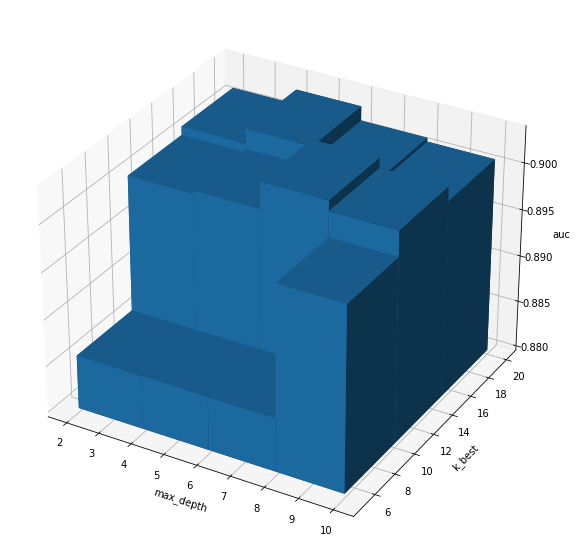

In [19]:
# setup the figure and axes
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')

_x = [2, 4, 6, 8]
_y = [5, 10, 15]
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = dt['mean_test_score']-0.88
bottom = np.zeros_like(top)+0.88
width = 2
depth = 5

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)

ax1.set_xlabel('max_depth')
ax1.set_ylabel('k_best')
ax1.set_zlabel('auc')

plt.show()

## Hyperopt
Hyperopt is a library for serial and parallel optimization.

To use hyperopt we need to describe:
1. The objective function to minimize
2. Search space
3. Database to be used for storing results 
4. Search algorithm

Unfortunately, documentation is poor for hyperopt library. Some detils may be found at <a href="https://github.com/hyperopt/hyperopt/wiki/FMin" target="_top">hyperopt tutorial</a>.

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [ ]:
# function to be minimized
def objective(params):
    tree = DecisionTreeClassifier(
        random_state=RANDOM_STATE, 
        max_depth=params['max_depth'],
        ccp_alpha=params['ccp_alpha']
    )
    scores = cross_val_score(estimator=tree, X=X_train, y=y_train, cv=3, n_jobs=4, scoring='roc_auc')
    
    return {
        'status': STATUS_OK,
        'loss': -np.mean(scores),
        'std_score': np.std(scores)
    }

# database for storing results
trials = Trials()

# space to be searched
search_space = {
    'max_depth': hp.quniform('max_depth', 1.9,8,1),
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.00025)
}

# actual minimization
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
#     algo=tpe.rand.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.RandomState(RANDOM_STATE)
)

In [ ]:
best

In [ ]:
import seaborn as sns

md = []
alpha = []
for tr in trials.trials:
    md.append(tr['misc']['vals']['max_depth'][0])
    alpha.append(tr['misc']['vals']['ccp_alpha'][0])
    
dt = pd.DataFrame(zip(md, alpha), columns=['max_depth', 'ccp_alpha'])

# plt.scatter(best['max_depth'], best['ccp_alpha'], marker='x', color='red')
p = sns.jointplot(data=dt, x="max_depth", y="ccp_alpha", kind='kde')
p.ax_joint.scatter(best['max_depth'], best['ccp_alpha'], marker='x', color='red', s=100)

plt.show()

In [ ]:
fig = plt.figure(figsize=(11,5))

plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
plt.plot(dt.index, dt['max_depth'])
plt.xlabel('iteration')
plt.ylabel('max_depth')
plt.plot(dt.index, dt['max_depth'].rolling(window=7).mean(), ls='--', color='black', lw=2)

plt.subplot(1,2,2)
plt.plot(dt.index, dt['ccp_alpha'])
plt.plot(dt.index, dt['ccp_alpha'].rolling(window=7).mean(), ls='--', color='black', lw=2)
plt.xlabel('iteration')
plt.ylabel('ccp_alpha')

plt.show()

## Genetic algorithm

In [ ]:
from scipy.optimize import differential_evolution
from sklearn.model_selection import cross_val_score

In [ ]:
res = []

def objective(params, X, y):
    ccp_alpha, max_depth = params
    max_depth = round(max_depth)
    
    tree = DecisionTreeClassifier(
        random_state=RANDOM_STATE, 
        max_depth=max_depth, 
        ccp_alpha=ccp_alpha
    )
    
    scores = cross_val_score(estimator=tree, X=X, y=y, cv=3, n_jobs=4, scoring='roc_auc')
    print(f'ccp_alpha: {ccp_alpha:.7f};   max_depth: {max_depth};   mean score: {np.mean(scores):.5f}')
    res.append((ccp_alpha, max_depth, np.mean(scores)))
    return -np.mean(scores)

In [ ]:
ccpalpha_bound = (0.0001, 0.00025)
maxdepth_bound = (1, 8)

boundaries = [ccpalpha_bound, maxdepth_bound]
solver = differential_evolution(
    objective,
    boundaries,
    args=(X_train, y_train),
    strategy='best1bin',
    maxiter=2,
    popsize=15,
    mutation=0.5,
    recombination=0.7,
    tol=0.01,
    seed=RANDOM_STATE
)

In [ ]:
print('Best parameters:')
print('----------------')
print(f'ccp_alpha:   {solver.x[0]}')
print(f'max_depth:   {round(solver.x[1])}')

In [ ]:
res = pd.DataFrame(res, columns=['ccp_alpha', 'max_depth', 'mean_score'])

fig = plt.figure(figsize=(11,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
sns.distplot(res['max_depth'], color='blue')

plt.subplot(1,2,2)
sns.distplot(res['ccp_alpha'], color='red')

plt.show()

<span style="color:red">**TO DO:** Optimize hyperparameters for an xgboost model. Define which parameters to optimize and compare multiple methods</span>

# Hyper-parameters optimization with neural networks

## Prepare data

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Load the mnist data
mnist_train, mnist_dev = tfds.load(
    "mnist",
    split=["train", "test"],
    as_supervised=True, # Include labels
    shuffle_files=False # Change to true for training
)

In [ ]:
# normalize data to interval [0;1]
mnist_train = mnist_train.map(lambda x, y: (tf.math.divide(x, 255), y))
mnist_dev = mnist_dev.map(lambda x, y: (tf.math.divide(x, 255), y))

In [ ]:
# plot few data samples
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(mnist_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(int(label))
    plt.axis('off')
    plt.plot()

In [ ]:
train_ds = mnist_train.cache().batch(64).prefetch(buffer_size=64)
validation_ds = mnist_dev.cache().batch(64).prefetch(buffer_size=64)

## Keras Tuner
Documentation: https://keras.io/keras_tuner/

In [ ]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [ ]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    model.add(tf.keras.layers.Dense(10))

    hp_optimizer = hp.Choice('optimizer', values=['Adam', 'RMSprop', 'SGD', 'Adagrad'])

    model.compile(
        optimizer=tf.keras.optimizers.get(hp_optimizer),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = RandomSearch(
    model_builder,
    objective="val_accuracy",
    max_trials=6,
    overwrite=True,
    directory="C:/Users/karel/repos/KBC",
    project_name="optimizer_opt",
    seed=RANDOM_STATE
)

In [ ]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
tuner.search(
    np.concatenate([x for x, y in train_ds], axis=0), 
    np.concatenate([y for x, y in train_ds], axis=0), 
    epochs=2, 
    validation_split=0.2, 
#     callbacks=[stop_early]
)

In [ ]:
tuner.get_best_hyperparameters(num_trials=1)[0].values

In [ ]:
tuner.results_summary()

## GridSearchCV with tensorflow

In [ ]:
def create_network(n_layers = 3, neurons_per_layer = 25, hl_activation = 'relu', initializer = 'uniform'):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.InputLayer(input_shape=(28,28)))
    model.add(tf.keras.layers.Flatten())
    for i in range(n_layers):
        model.add(tf.keras.layers.Dense(
            units=neurons_per_layer, 
            activation = hl_activation,
            kernel_initializer = initializer
        ))
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
    
    model.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = KerasClassifier(
    build_fn=create_network, 
    epochs=5, 
    batch_size=64, 
    verbose=1
)

param_grid = {
    'initializer': ['uniform', 'zeros'],
    'hl_activation': ['relu', 'sigmoid']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2)
grid_result = grid.fit(
    np.concatenate([x for x, y in train_ds], axis=0), 
    np.concatenate([y for x, y in train_ds], axis=0),
)

In [ ]:
grid_result.best_params_

In [ ]:
grid_result.cv_results_

## Tensorboard

In [ ]:
# use "tensorboard --logdir logs" in command line

n_layers = 3

initializer = ['uniform', 'lecun_uniform']
hl_activation = ['relu', 'sigmoid']

for init in initializer:
    for activ in hl_activation:
        model = tf.keras.models.Sequential()

        model.add(tf.keras.layers.InputLayer(input_shape=(28,28)))
        model.add(tf.keras.layers.Flatten())
        for i in range(n_layers):
            model.add(tf.keras.layers.Dense(
                units=25, 
                activation = activ,
                kernel_initializer = init
            ))
        model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

        model.compile(
            optimizer=tf.optimizers.Adam(),
            loss=tf.losses.SparseCategoricalCrossentropy(),
            metrics=['sparse_categorical_accuracy'],
        )

        log_dir = f'logs/{init}_{activ}'
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        model.fit(
            np.concatenate([x for x, y in train_ds], axis=0), 
            np.concatenate([y for x, y in train_ds], axis=0),
            epochs=5,
            batch_size=64,
            callbacks=[tensorboard_callback],
            validation_data = validation_ds
        )

<span style="color:red">**TO DO:** Optimize hyperparameters for a convolutional neural network</span>